In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError
from typing import List, Tuple

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.VariableEncoder.datasets.dataset import CustomDataset
from models.VariableEncoder.training.configs import TrainingConfig
from models.VariableEncoder.training.configs import TrainingRunConfig


def get_normal_dataset(config: TrainingConfig) -> Tuple[CustomDataset, torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    src_var_list = var_vocab.get_code(vars)
    tgt_var_list = var_vocab.get_code(config.air_variable + config.surface_variable)

    dataset = CustomDataset(source, config.src_time_len, config.tgt_time_len, n_only_input=len(config.only_input_variable)+len(config.constant_variable))
    return dataset, mean_std, (src_var_list, tgt_var_list)


config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, mean_std, var_list = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                    (time: 87649, latitude: 36, longitude: 36,
                                level: 8)
Coordinates:
  * latitude                   (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                      (level) int64 50 100 250 500 600 700 850 925
  * longitude                  (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                       (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables: (12/14)
    10m_u_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature             (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential               (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 8, 36, 36), meta=n

100%|██████████| 12/12 [00:28<00:00,  2.34s/it]


29.17743 sec


In [2]:
%load_ext autoreload
%autoreload 2

from models.VariableEncoder.training.lightning import TrainModule, denormalize, rmse_loss, positional_encoding, get_var_seq, get_tgt_mask

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/VariableEncoder/tb_logs/lightning_logs/p18vmely/checkpoints/epoch=6-step=49056.ckpt')

/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [3]:
def predict(model: TrainModule, batch, device):
    src, label = batch
    src = src.to(device)
    label = label.to(device)
    tgt = label[:, :1]

    for i in range(1, config.training.tgt_time_len):
        src_seq, tgt_seq = get_var_seq(var_list[0], var_list[1], config.training.src_time_len, config.training.tgt_time_len, src.size(0))
        tgt_mask = get_tgt_mask(var_list[1].size(0), config.training.tgt_time_len).to(device)
        src_seq = src_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        input = torch.cat([tgt, torch.zeros(tgt.size(0), config.training.src_time_len-i, tgt.size(2), tgt.size(3), device=device)], dim=1)

        predict = model.model(src, input, src_seq, tgt_seq, tgt_mask)
        # predict.shape = (batch, i * var + 1, hidden)
        start = (i-1) * var_list[1].size(0)
        end = (i) * var_list[1].size(0)
        predict = predict.cpu().detach()
        predict = predict[:, start:end].unsqueeze(1)
        predict = predict.to(device)
        tgt = torch.cat([tgt, predict], dim=1)

        input.cpu().detach()
        src_seq.cpu().detach()
        tgt_seq.cpu().detach()
        tgt_mask.cpu().detach()
        predict.cpu().detach()
    
    label = label[:, 1:]
    
    tgt = tgt.view(tgt.size(0), config.training.tgt_time_len, var_list[1].size(0), tgt.size(-1))
    # loss.shape = (batch, time_len * var_len, 1450)
    loss = model.calculate_sqare_loss(tgt, label)
    # loss.shape = (batch, var_len, time_len, 1450)
    loss = loss.swapaxes(1, 2)
    # loss.shape = (batch, var_len, time_len)
    loss = torch.mean(loss, dim=-1)
    # loss.shape = (var_len, batch, time_len)
    loss = loss.swapaxes(0, 1)

    src.cpu().detach()
    label.cpu().detach()
    predict.cpu().detach()
    loss = loss.cpu().detach()
    
    return loss

In [4]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = ("cuda" if torch.cuda.is_available() else "cpu" )
device = torch.device(device)

train_ds, test_ds = torch.utils.data.random_split(
             dataset,
            [0.99, 0.01],
        )

data_loader = DataLoader(test_ds, batch_size=6, shuffle=True, drop_last=True)

loss_set = []

model.model.eval()
model.setting()

for batch in tqdm(data_loader):
    loss = predict(model, batch, device)
    loss_set.append(loss)


loss_set = torch.cat(loss_set, dim=1)

  0%|          | 0/146 [00:00<?, ?it/s]

 39%|███▉      | 57/146 [04:51<07:34,  5.10s/it]

In [9]:
loss = loss_set.mean(dim=1)

In [10]:
print(loss.shape)
print(loss)

torch.Size([84, 12])
tensor([[3.1336e+03, 5.1753e+04, 8.1785e+04,  ..., 2.0026e+05, 2.0696e+05,
         2.2826e+05],
        [2.1924e+03, 4.5263e+04, 8.6227e+04,  ..., 3.6690e+05, 3.9646e+05,
         4.3559e+05],
        [2.3004e+03, 5.5420e+04, 1.0893e+05,  ..., 3.9647e+05, 4.2670e+05,
         4.7294e+05],
        ...,
        [2.4333e+03, 1.1717e+04, 2.1824e+04,  ..., 7.4484e+04, 8.0450e+04,
         8.7554e+04],
        [1.3320e-02, 3.0030e-02, 3.9842e-02,  ..., 8.5718e-02, 9.0948e-02,
         9.5781e-02],
        [6.4406e-08, 1.5425e-07, 1.8089e-07,  ..., 2.9185e-07, 3.0490e-07,
         3.1749e-07]])


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(loss: torch.Tensor, title, isAIR = False, level=None):
    if isAIR:
        loss = loss.swapaxes(0, 1)
        if level is not None:
            loss = loss[:, level]
        
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([12])


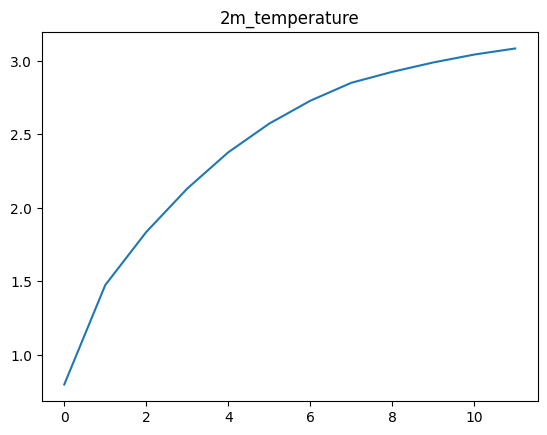

torch.Size([12])


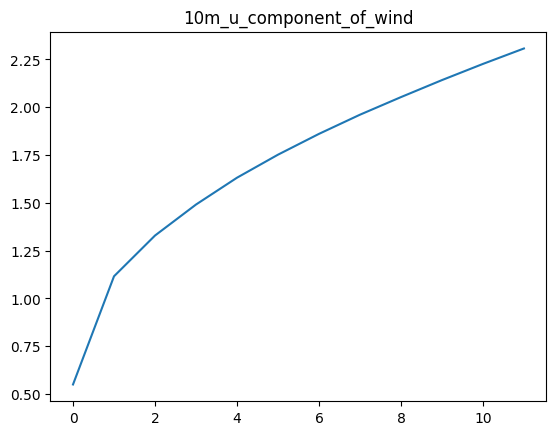

torch.Size([12])


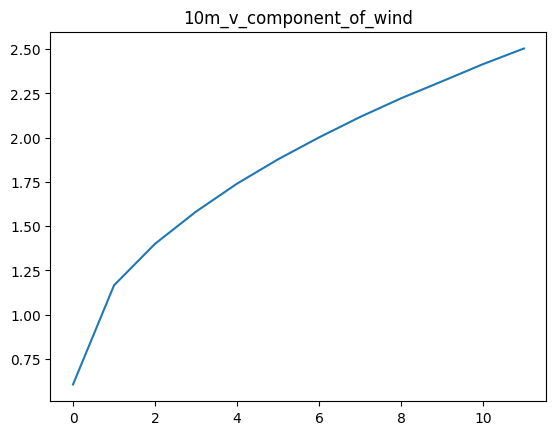

torch.Size([12])


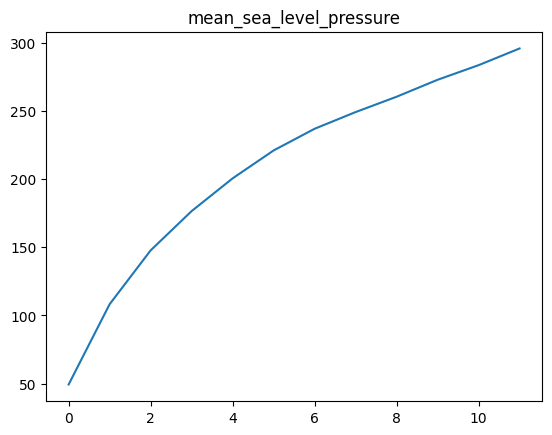

torch.Size([12])


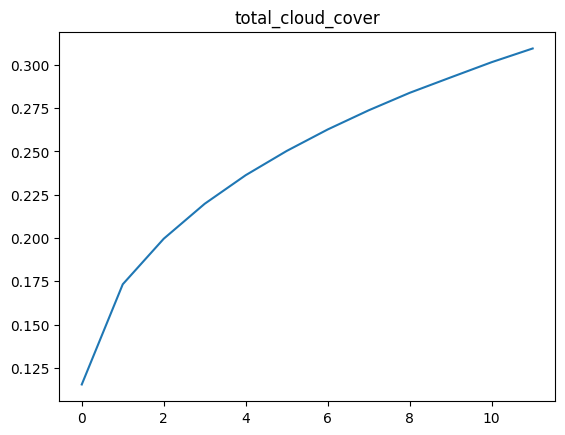

torch.Size([12])


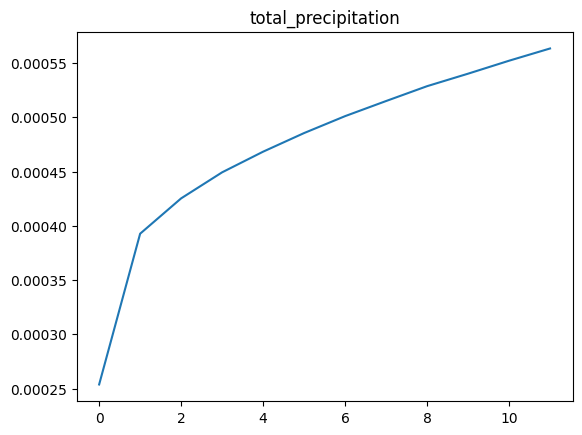

In [12]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(loss[idx]), var, isAIR=False)

torch.Size([12])


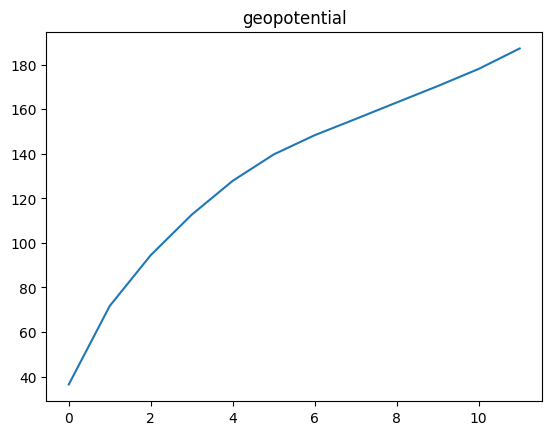

torch.Size([12])


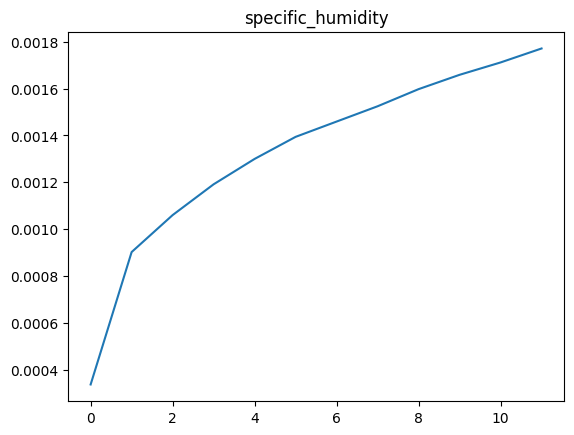

torch.Size([12])


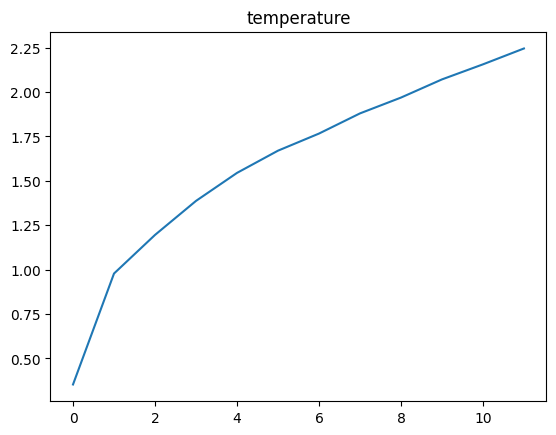

torch.Size([12])


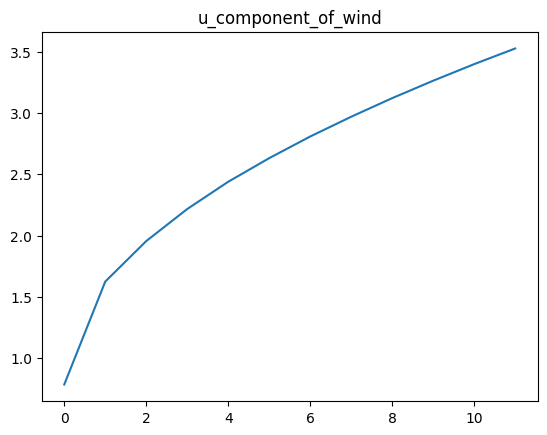

torch.Size([12])


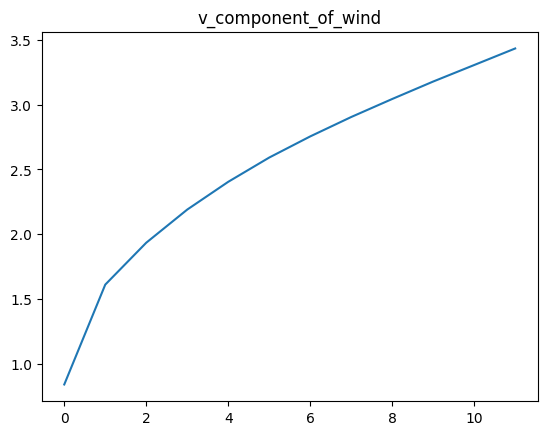

torch.Size([12])


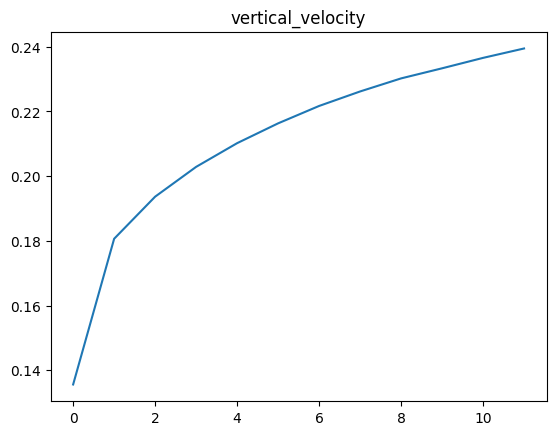

In [13]:
for idx, var in enumerate(config.training.air_variable):
        air_list = [ ((idx)*len(config.training.levels)) + i for i in range(len(config.training.levels))]
        visualize(torch.sqrt(loss[air_list]), var, isAIR=True, level=-3)